In [63]:
import numpy
import math

import random
import time
import matplotlib.pyplot as plt

In [91]:
environment = numpy.zeros((7, 7))
trans_prob = 1
environment[6, 6] = 10
#environment[8, 8] = -10
#environment[2, 3] = -5

In [65]:
alpha = 0.1
gamma = 0.9

In [66]:
def get_legal_actions(pos):
    legal_actions = list()
    new_pos = list()
    all_actions = [[1, 0], [0, 1], [-1, 0], [0, -1]]
    for i in all_actions:
        try:
            new_pos = numpy.add(pos, numpy.array(i))
            legal_actions.append(i)
            env = environment[new_pos[0]][new_pos[1]]
            if any(j < 0 for j in new_pos):
                legal_actions.pop()
        except IndexError:
            legal_actions.pop()
            
        
    return legal_actions

In [67]:
def take_action(pos, action):
    # Take action in the actual environment and return a reward and new position based on environment dynamics
    if numpy.random.rand(1) < trans_prob:
        new_pos = numpy.add(pos, action)
    else:
        new_pos = numpy.add(pos, random.choice(get_legal_actions(pos)))
    reward = environment[new_pos[0]][new_pos[1]]
    return new_pos, reward

In [68]:
print "legal actions", get_legal_actions(numpy.array([1, 1]))
print take_action(numpy.array([1, 1]), [0, -1])


legal actions [[1, 0], [0, 1], [-1, 0], [0, -1]]
(array([1, 0]), 0.0)


In [92]:
mb_internal_environment = numpy.zeros((7, 7))


In [70]:
def mb_internal_environment_value(pos, mb_internal_environment):
    value = mb_internal_environment[pos[0], pos[1]]
    return value

In [71]:
def update_mb_internal_environment(pos, next_pos, reward, mb_internal_environment):
    next_value_list = list()
    for i in get_legal_actions(next_pos):
        next_value_list.append(mb_internal_environment[next_pos[0]][next_pos[1]])
    next_value = max(next_value_list)
    mb_internal_environment[pos[0], pos[1]] = (1-alpha) * mb_internal_environment_value(pos, mb_internal_environment) + (alpha) * (reward + gamma*next_value) - 0.1
    return mb_internal_environment


In [72]:
def dls(pos, curr_depth, max_depth, mb_internal_environment):
    value_list = list()
    if curr_depth == max_depth:
        return mb_internal_environment_value(pos, mb_internal_environment)
    else:
        actions = get_legal_actions(pos)
        for i in actions:
            next_pos = numpy.add(numpy.array(pos), numpy.array(i))
            value = mb_internal_environment_value(pos, mb_internal_environment) + gamma * dls(next_pos, curr_depth+1, max_depth, mb_internal_environment)
            value_list.append(value)
        if value_list:
            average_value = numpy.mean(numpy.array(value_list))
    return average_value

In [73]:
def dls_action(pos, max_depth, mb_internal_environment):
    # Do depth Limited Search till max_depth on the mb_internal_environment
    actions = get_legal_actions(pos)
    next_value_list = list()
    next_pos_list = list()
    for i in actions:
        next_pos = numpy.add(numpy.array(pos), numpy.array(i))
        next_value_list.append(dls(next_pos, 0, max_depth, mb_internal_environment))
        next_pos_list.append(next_pos)
    random.shuffle(actions)
    action = actions[numpy.argmax(next_value_list)]
    return action

In [74]:
def q_action(pos, mb_internal_environment):
    # Look for q values in mf_internal_environment for given position
    actions = get_legal_actions(pos)
    next_value_list = list()
    next_pos_list = list()
    for i in actions:
        next_pos = numpy.add(numpy.array(pos), numpy.array(i))
        next_value_list.append(mb_internal_environment[next_pos[0], next_pos[1]])
        next_pos_list.append(next_pos)
    random.shuffle(actions)
    action = actions[numpy.argmax(next_value_list)]
    return action

In [75]:
def dual(num_iters, mb_internal_environment):
    sum_reward = 0
    max_depth = 4
    steps_per_reward = 0
    steps = list()
    for i in range(num_iters):
        pos = [0, 0]
        j = 0
        while True:
            if j%(i+1) == 0:
                action = dls_action(pos, max_depth, mb_internal_environment)
                print "Here"
                next_pos, reward = take_action(pos, action)
                mb_internal_environment = update_mb_internal_environment(pos, next_pos, reward, mb_internal_environment)
                pos = next_pos
            else:
                action = q_action(pos, mb_internal_environment)
                print "Or Here"
                next_pos, reward = take_action(pos, action)
                mb_internal_environment = update_mb_internal_environment(pos, next_pos, reward, mb_internal_environment)
                pos = next_pos
            print "Pos", pos
            sum_reward = 0.5*sum_reward + 0.5*reward
            steps_per_reward += 1
            j += 1
            if reward != 0:
                mb_internal_environment[pos[0], pos[1]] = (1-alpha) * mb_internal_environment_value(pos, mb_internal_environment) + (alpha) * (reward)
                steps.append(steps_per_reward)
                steps_per_reward = 0
                #print "here", pos
                break
    return sum_reward, steps, mb_internal_environment

In [76]:
def mb(num_iters, mb_internal_environment):
    sum_reward = 0
    max_depth = 4
    steps = list()
    for i in range(num_iters):
        pos = [0, 0]
        steps_per_reward = 0
        #print (mb_internal_environment)    
     
        while True:
            action = dls_action(pos, max_depth, mb_internal_environment)
            next_pos, reward = take_action(pos, action)
            mb_internal_environemnt = update_mb_internal_environment(pos, next_pos, reward, mb_internal_environment)
            pos = next_pos
            print "Pos", pos
            sum_reward = 0.5*sum_reward + 0.5*reward
            steps_per_reward += 1
            if reward != 0:
                mb_internal_environment[pos[0], pos[1]] = (1-alpha) * mb_internal_environment_value(pos, mb_internal_environment) + (alpha) * (reward)                
                steps.append(steps_per_reward)
                steps_per_reward = 0
                #print "here"
                break

    return sum_reward, steps, mb_internal_environment

In [77]:
def mf(num_iters, mb_internal_environment):
    sum_reward = 0
    max_depth = 9
    steps = list()
    for i in range(num_iters):
        pos = [0, 0]
        steps_per_reward = 0        
        #print (mb_internal_environment)
        
        while True:
            action = q_action(pos, mb_internal_environment)
            next_pos, reward = take_action(pos, action)
            mb_internal_environment = update_mb_internal_environment(pos, next_pos, reward, mb_internal_environment)
            pos = next_pos
            print "Pos", pos
            sum_reward = 0.5*sum_reward + 0.5*reward
            steps_per_reward += 1
            if reward != 0:
                
                mb_internal_environment[pos[0], pos[1]] = (1-alpha) * mb_internal_environment_value(pos, mb_internal_environment) + (alpha) * (reward)
                steps.append(steps_per_reward)
                steps_per_reward = 0
                break
            
    return sum_reward, steps, mb_internal_environment, mb_internal_environment

In [78]:
mb_internal_environment = numpy.zeros((7, 7))
mb_internal_environment[4, 4] = 10
print mb_internal_environment

[[  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  10.]]


Run the Dual Process on grid world. Get a list of individual time taken for each and rewards obtained.

In [93]:
times_dual = list()
reward_dual = list()
steps_dual = list()
for i in range(1):
    mb_internal_environment = numpy.zeros((7, 7))
    mb_internal_environment[6, 6] = 10
    start_time = time.time()
    dual_result = dual(3, mb_internal_environment)
    reward_dual.append(dual_result[0])
    steps_dual.append(dual_result[1])
    times_dual.append(time.time() - start_time)


Here
Pos [0 1]
Here
Pos [1 1]
Here
Pos [0 1]
Here
Pos [1 1]
Here
Pos [1 2]
Here
Pos [2 2]
Here
Pos [1 2]
Here
Pos [2 2]
Here
Pos [2 1]
Here
Pos [1 1]
Here
Pos [2 1]
Here
Pos [3 1]
Here
Pos [3 2]
Here
Pos [4 2]
Here
Pos [4 3]
Here
Pos [4 2]
Here
Pos [4 1]
Here
Pos [5 1]
Here
Pos [6 1]
Here
Pos [5 1]
Here
Pos [5 0]
Here
Pos [5 1]
Here
Pos [5 0]
Here
Pos [4 0]
Here
Pos [4 1]
Here
Pos [4 2]
Here
Pos [3 2]
Here
Pos [2 2]
Here
Pos [2 1]
Here
Pos [1 1]
Here
Pos [1 0]
Here
Pos [0 0]
Here
Pos [1 0]
Here
Pos [1 1]
Here
Pos [1 0]
Here
Pos [1 1]
Here
Pos [0 1]
Here
Pos [1 1]
Here
Pos [1 2]
Here
Pos [2 2]
Here
Pos [1 2]
Here
Pos [1 1]
Here
Pos [1 0]
Here
Pos [0 0]
Here
Pos [0 1]
Here
Pos [1 1]
Here
Pos [1 0]
Here
Pos [0 0]
Here
Pos [1 0]
Here
Pos [1 1]
Here
Pos [1 2]
Here
Pos [0 2]
Here
Pos [0 3]
Here
Pos [0 2]
Here
Pos [1 2]
Here
Pos [1 1]
Here
Pos [2 1]
Here
Pos [3 1]
Here
Pos [4 1]
Here
Pos [4 2]
Here
Pos [5 2]
Here
Pos [5 1]
Here
Pos [6 1]
Here
Pos [5 1]
Here
Pos [6 1]
Here
Pos [6 0]
Here
Pos [

In [94]:
times_mb = list()
reward_mb = list()
steps_mb = list()
for i in range(1):
    mb_internal_environment = numpy.zeros((7, 7))
    mb_internal_environment[6, 6] = 10
    start_time = time.time()
    mb_result = mb(3, mb_internal_environment)
    print i
    reward_mb.append(mb_result[0])
    steps_mb.append(mb_result[1])
    times_mb.append(time.time() - start_time)


Pos [0 1]
Pos [1 1]
Pos [0 1]
Pos [0 2]
Pos [0 3]
Pos [0 4]
Pos [1 4]
Pos [1 5]
Pos [1 6]
Pos [1 5]
Pos [1 6]
Pos [0 6]
Pos [1 6]
Pos [1 5]
Pos [2 5]
Pos [3 5]
Pos [2 5]
Pos [3 5]
Pos [4 5]
Pos [5 5]
Pos [5 4]
Pos [4 4]
Pos [4 5]
Pos [4 6]
Pos [4 5]
Pos [5 5]
Pos [4 5]
Pos [5 5]
Pos [4 5]
Pos [4 6]
Pos [3 6]
Pos [4 6]
Pos [3 6]
Pos [2 6]
Pos [3 6]
Pos [3 5]
Pos [3 4]
Pos [4 4]
Pos [3 4]
Pos [4 4]
Pos [4 3]
Pos [3 3]
Pos [3 4]
Pos [2 4]
Pos [3 4]
Pos [3 3]
Pos [3 4]
Pos [3 3]
Pos [3 4]
Pos [2 4]
Pos [2 5]
Pos [3 5]
Pos [2 5]
Pos [1 5]
Pos [2 5]
Pos [1 5]
Pos [0 5]
Pos [0 4]
Pos [1 4]
Pos [0 4]
Pos [1 4]
Pos [1 5]
Pos [1 4]
Pos [2 4]
Pos [2 3]
Pos [1 3]
Pos [0 3]
Pos [1 3]
Pos [1 4]
Pos [2 4]
Pos [2 3]
Pos [2 2]
Pos [3 2]
Pos [3 1]
Pos [3 0]
Pos [2 0]
Pos [2 1]
Pos [3 1]
Pos [4 1]
Pos [3 1]
Pos [3 0]
Pos [4 0]
Pos [3 0]
Pos [2 0]
Pos [2 1]
Pos [1 1]
Pos [0 1]
Pos [1 1]
Pos [1 2]
Pos [0 2]
Pos [0 3]
Pos [1 3]
Pos [2 3]
Pos [3 3]
Pos [3 2]
Pos [2 2]
Pos [2 1]
Pos [2 0]
Pos [2 1]
Pos [2 0]


In [95]:
times_mf = list()
reward_mf = list()
steps_mf = list()
for i in range(1):
    mb_internal_environment = numpy.zeros((7, 7))
    mb_internal_environment[6, 6] = 10
    start_time = time.time()
    mf_result = mf(3, mb_internal_environment)
    reward_mf.append(mf_result[0])
    steps_mf.append(mf_result[1])
    times_mf.append(time.time() - start_time)


Pos [0 1]
Pos [0 0]
Pos [0 1]
Pos [0 2]
Pos [0 1]
Pos [0 0]
Pos [1 0]
Pos [1 1]
Pos [1 0]
Pos [2 0]
Pos [3 0]
Pos [3 1]
Pos [2 1]
Pos [1 1]
Pos [2 1]
Pos [1 1]
Pos [2 1]
Pos [3 1]
Pos [3 0]
Pos [2 0]
Pos [3 0]
Pos [2 0]
Pos [2 1]
Pos [2 2]
Pos [2 1]
Pos [2 2]
Pos [2 1]
Pos [2 0]
Pos [2 1]
Pos [2 2]
Pos [1 2]
Pos [1 1]
Pos [2 1]
Pos [1 1]
Pos [2 1]
Pos [2 0]
Pos [2 1]
Pos [2 0]
Pos [2 1]
Pos [3 1]
Pos [4 1]
Pos [4 2]
Pos [5 2]
Pos [4 2]
Pos [4 1]
Pos [4 0]
Pos [5 0]
Pos [4 0]
Pos [3 0]
Pos [4 0]
Pos [5 0]
Pos [5 1]
Pos [4 1]
Pos [4 2]
Pos [5 2]
Pos [6 2]
Pos [6 3]
Pos [6 4]
Pos [5 4]
Pos [5 5]
Pos [5 4]
Pos [4 4]
Pos [4 3]
Pos [4 2]
Pos [4 3]
Pos [4 2]
Pos [5 2]
Pos [5 3]
Pos [6 3]
Pos [6 2]
Pos [5 2]
Pos [4 2]
Pos [4 3]
Pos [4 2]
Pos [4 1]
Pos [3 1]
Pos [4 1]
Pos [3 1]
Pos [4 1]
Pos [4 0]
Pos [3 0]
Pos [3 1]
Pos [3 2]
Pos [4 2]
Pos [3 2]
Pos [3 1]
Pos [4 1]
Pos [3 1]
Pos [4 1]
Pos [5 1]
Pos [6 1]
Pos [6 0]
Pos [6 1]
Pos [6 2]
Pos [6 3]
Pos [5 3]
Pos [5 4]
Pos [5 5]
Pos [4 5]
Pos [3 5]


In [96]:
print mb_internal_environment

[[ -2.4035592   -2.77688695  -3.03087541  -1.97961137  -1.64593651
   -1.22416928  -0.85213415]
 [ -2.30007637  -2.83850843  -3.11941751  -2.33671429  -1.94766733
   -1.42742014  -1.23635513]
 [ -1.80618259  -2.55074358  -2.72369098  -2.35672037  -1.84982315
   -1.67578529  -1.37499857]
 [ -1.11611868  -1.99856771  -2.05533895  -1.93000524  -1.54553681
   -1.72696986  -1.40643261]
 [ -0.98749164  -1.94207549  -2.11758361  -1.74484591  -1.46043166
   -1.26929738  -0.17219555]
 [ -0.82113915  -1.290367    -1.47459275  -1.57186445  -1.47307916
   -0.89177911   4.19814582]
 [ -0.62819093  -1.11670861  -1.03487543  -0.9664748   -0.81774792
   -0.66989421  10.        ]]


[ 248.  482.  152.]
[ 252.  108.  132.]
[ 148.  100.  310.]


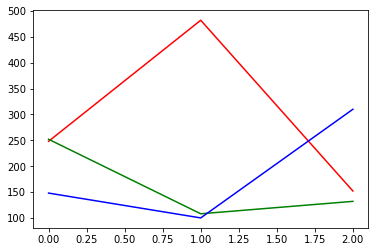

In [97]:
#print (sum(steps_mf)/300)
#print (sum(steps_mb)/300)

#print (sum(steps_dual)/300)
print (numpy.mean(numpy.array(steps_mf), axis=0))
print (numpy.mean(numpy.array(steps_dual), axis=0))
print (numpy.mean(numpy.array(steps_mb), axis=0))

stepsmf_plot, = plt.plot(numpy.arange(0, 3), numpy.mean(numpy.array(steps_mf), axis=0), color = 'r')
stepsdual_plot, = plt.plot(numpy.arange(0, 3), numpy.mean(numpy.array(steps_dual), axis=0), color = 'g')
stepsmb_plot, = plt.plot(numpy.arange(0, 3), numpy.mean(numpy.array(steps_mb), axis=0), color = 'b')

#plt.xticks(numpy.arange(3), ('mb', 'dual', 'mf'))
plt.show()

In [98]:
reward_mean_dual = numpy.mean(numpy.array(reward_dual))
reward_mean_mb = numpy.mean(numpy.array(reward_mb))
reward_mean_mf = numpy.mean(numpy.array(reward_mf))
times_mean_dual = numpy.mean(numpy.array(times_dual))
times_mean_mb = numpy.mean(numpy.array(times_mb))
times_mean_mf = numpy.mean(numpy.array(times_mf))
steps_mean_dual = sum(steps_dual[0])
steps_mean_mb = sum(steps_mb[0])
steps_mean_mf = sum(steps_mf[0])


In [99]:
print steps_mf

[[248, 482, 152]]


In [100]:
3%5

3

In [101]:
rewards = numpy.array([reward_mean_mb, reward_mean_dual, reward_mean_mf])
#yerror = numpy.array(reward_errors)
print (rewards)

[ 5.  5.  5.]


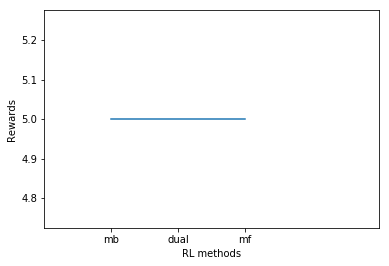

In [102]:
reward_plot, = plt.plot(numpy.arange(0, 3), rewards)
plt.xticks(numpy.arange(3), ('mb', 'dual', 'mf'))
plt.xlim(xmin = -1, xmax = 4)
#plt.ylim(ymin = 4.5, ymax = 5.5)
plt.xlabel('RL methods')
plt.ylabel("Rewards")

plt.show()

[ 14.08351779   8.95735097   0.83576298]


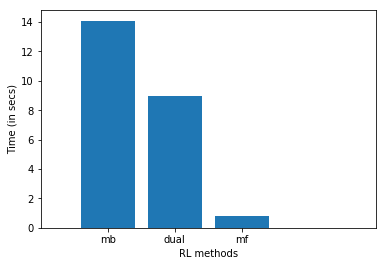

In [103]:
times = numpy.array([times_mean_mb, times_mean_dual, times_mean_mf])
print (times)
plt.bar(numpy.arange(3), times, align='center')
plt.xticks(numpy.arange(3), ('mb', 'dual', 'mf'))
plt.xlim(xmin = -1, xmax = 4)
#plt.ylim(ymin = -1, ymax = 10)
plt.xlabel('RL methods')
plt.ylabel("Time (in secs)")

plt.show()

[558 492 882]


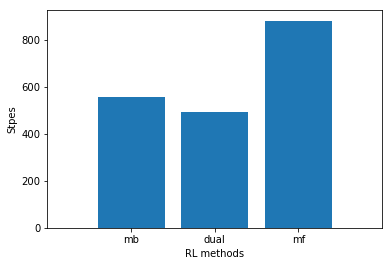

In [104]:
steps = numpy.array([steps_mean_mb, steps_mean_dual, steps_mean_mf])
print (steps)
plt.bar(numpy.arange(3), steps, align='center')
plt.xticks(numpy.arange(3), ('mb', 'dual', 'mf'))
plt.xlim(xmin = -1, xmax = 3)
#plt.ylim(ymin = 350, ymax = 400)
plt.xlabel('RL methods')
plt.ylabel("Stpes")

plt.show()